In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

In [6]:
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [7]:
CLASS_NAMES= ['healthy', 'mild', 'moderate', 'severe']
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
NUM_CLASSES = len(CLASS_NAMES)

# **ResNET**

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
#load data
data_x = np.load('data_x_aumentated.npy') #images
data_y = np.load('data_y_aumentated.npy') #labels
TOTAL_IMAGES = len(data_y)
print("TOTAL_IMAGES = ", TOTAL_IMAGES)

TOTAL_IMAGES =  2368


# **Splitting data in train - validation - test**

In [10]:
#percentage of the dataset which will be on TRAIN - TEST - VALIDATION
TRAIN_PERCENTAGE = 0.8
TEST_PERCENTAGE = 0.1
VALIDATION_PERCENTAGE = 0.1

In [11]:
train_size = int(TRAIN_PERCENTAGE * TOTAL_IMAGES)
test_size = int(TEST_PERCENTAGE * TOTAL_IMAGES)
validation_size = int(VALIDATION_PERCENTAGE * TOTAL_IMAGES)

In [12]:
train_x = data_x[:train_size]
train_y = data_y[:train_size]
data_x = data_x[train_size:]
data_y = data_y[train_size:]

test_x = data_x[:test_size]
test_y = data_y[:test_size]
data_x = data_x[test_size:]
data_y = data_y[test_size:]

validation_x = data_x #all the remainder we can let on validation
validation_y = data_y
del data_x
del data_y

In [13]:
print("train_size = ", len(train_y))
print("test_size = ", len(test_y))
print("validation_size = ", len(validation_y))

train_size =  1894
test_size =  236
validation_size =  238


In [14]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from IPython.display import SVG
import scipy.misc

In [16]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
# from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.applications import EfficientNetB6
# from tensorflow.keras.applications import EfficientNetB7
# from tensorflow.keras.applications import *

In [17]:
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\tmcle\miniconda3\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [18]:
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS),
    pooling=None,
    classes=NUM_CLASSES,
   # classifier_activation="softmax",
#    **kwargs
)

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers

new_model = models.Sequential()
new_model.add(model)
#3rd conv layer
new_model.add(tf.keras.layers.Conv2D(32, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#4th conv layer
new_model.add(tf.keras.layers.Conv2D(64, 3, padding="same"))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.MaxPooling2D(2))
#Flatten Layer
new_model.add(tf.keras.layers.Flatten())

new_model.add(tf.keras.layers.Dense(128, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
new_model.add(tf.keras.layers.BatchNormalization())
new_model.add(tf.keras.layers.Activation("relu"))
new_model.add(tf.keras.layers.Dropout(0.2))
#new_model.add(tf.keras.layers.l2( l=0.01))
#new_model.add(layers.GlobalAveragePooling2D())
#output Dense Layer
new_model.add(tf.keras.layers.Dense(NUM_CLASSES))
new_model.add(tf.keras.layers.Activation('softmax'))
adam = tf.keras.optimizers.Adam(lr=0.001)


C:\Users\tmcle\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 32)          589856    
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 4, 4, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          1

In [22]:
epochs = 100

#compila e treina o modelo com os dados carregados
new_model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=adam)
model_trained = new_model.fit(train_x, train_y,epochs=epochs,verbose=1,validation_data=(validation_x, validation_y),shuffle=False)

Epoch 1/100
60/60 [==============================] - 38s 402ms/step - loss: 1.6866 - acc: 0.6373 - val_loss: 7.7394 - val_acc: 0.2563
Epoch 2/100
60/60 [==============================] - 21s 347ms/step - loss: 1.0890 - acc: 0.8300 - val_loss: 7.5309 - val_acc: 0.2605
Epoch 3/100
60/60 [==============================] - 21s 345ms/step - loss: 0.7840 - acc: 0.8918 - val_loss: 11.0928 - val_acc: 0.2563
Epoch 4/100
60/60 [==============================] - 20s 341ms/step - loss: 0.6433 - acc: 0.9023 - val_loss: 9.0169 - val_acc: 0.1261
Epoch 5/100
60/60 [==============================] - 20s 339ms/step - loss: 0.4778 - acc: 0.9250 - val_loss: 7.4982 - val_acc: 0.2563
Epoch 6/100
60/60 [==============================] - 21s 344ms/step - loss: 0.3266 - acc: 0.9641 - val_loss: 6.2638 - val_acc: 0.2563
Epoch 7/100
60/60 [==============================] - 20s 335ms/step - loss: 0.2674 - acc: 0.9657 - val_loss: 1.8083 - val_acc: 0.6345
Epoch 8/100
60/60 [==============================] - 20s 335m

60/60 [==============================] - 21s 347ms/step - loss: 4.0590e-04 - acc: 1.0000 - val_loss: 0.1977 - val_acc: 0.9496
Epoch 62/100
60/60 [==============================] - 21s 351ms/step - loss: 3.9408e-04 - acc: 1.0000 - val_loss: 0.1996 - val_acc: 0.9412
Epoch 63/100
60/60 [==============================] - 21s 354ms/step - loss: 3.7554e-04 - acc: 1.0000 - val_loss: 0.1963 - val_acc: 0.9454
Epoch 64/100
60/60 [==============================] - 20s 339ms/step - loss: 3.9420e-04 - acc: 1.0000 - val_loss: 0.1941 - val_acc: 0.9412
Epoch 65/100
60/60 [==============================] - 20s 337ms/step - loss: 3.6495e-04 - acc: 1.0000 - val_loss: 0.1955 - val_acc: 0.9454
Epoch 66/100
60/60 [==============================] - 20s 332ms/step - loss: 3.7790e-04 - acc: 1.0000 - val_loss: 0.2016 - val_acc: 0.9454
Epoch 67/100
60/60 [==============================] - 20s 332ms/step - loss: 3.6658e-04 - acc: 1.0000 - val_loss: 0.2061 - val_acc: 0.9412
Epoch 68/100
60/60 [====================

In [23]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [24]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [25]:
#print(getLayerIndexByName(new_model, 'flatten_1')) #just used to get the index of flatten layer

In [26]:
model_name = f'resnet50-baseline-holdout-{epochs}epochs.npy'
model.save(model_name)

INFO:tensorflow:Assets written to: resnet50-baseline-holdout-100epochs.npy\assets


INFO:tensorflow:Assets written to: resnet50-baseline-holdout-100epochs.npy\assets


**Random Forest**

In [27]:
new_model_rf = keras.Model(inputs=new_model.input, outputs=new_model.get_layer(index=9).output)
featureVector = new_model_rf.predict(train_x)

60/60 [==============================] - 8s 77ms/step


In [28]:
featureVector2 = new_model_rf.predict(test_x)

8/8 [==============================] - 3s 142ms/step


In [29]:
print(featureVector.shape)

(1894, 64)


In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(featureVector,train_y)



RandomForestClassifier()

In [32]:
test_x.shape

(236, 128, 128, 3)

In [33]:
y_pred=clf.predict(featureVector2)

In [34]:
featureVector.shape

(1894, 64)

In [35]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(test_y, y_pred))

Accuracy: 0.9661016949152542


In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
clf = DecisionTreeClassifier(random_state=0)

# **Testes**

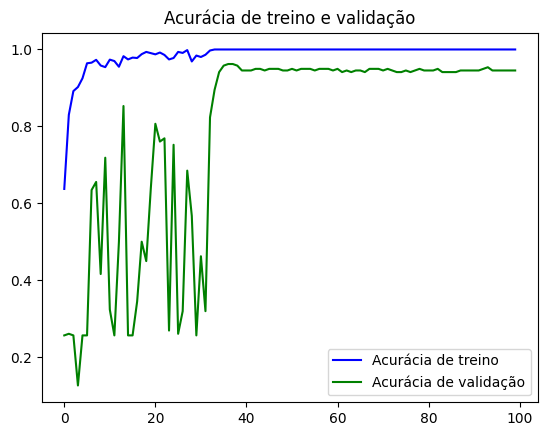

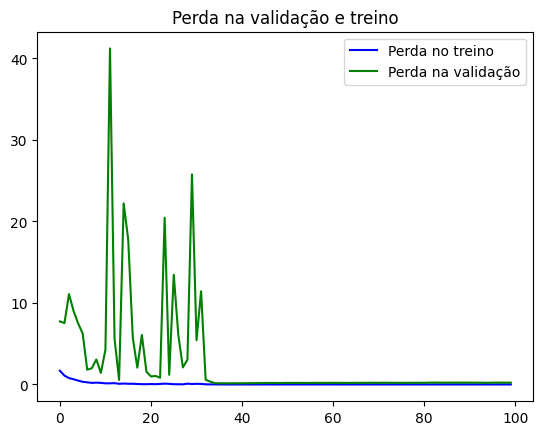

In [38]:
import matplotlib.pyplot as plt

accuracy = model_trained.history['acc']
val_accuracy = model_trained.history['val_acc']
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Acurácia de treino')
plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Perda no treino')
plt.plot(epochs, val_loss, 'g', label='Perda na validação')
plt.title('Perda na validação e treino')
plt.legend()
plt.show()

In [39]:
#avalia a fase de teste

model_loss, model_accuracy = new_model.evaluate(test_x, test_y, verbose=1)

#mostra o resultado
print('Test loss:', model_loss)
print('Test accuracy:', model_accuracy)

8/8 [==============================] - 3s 80ms/step - loss: 0.1419 - acc: 0.9703
Test loss: 0.14187610149383545
Test accuracy: 0.9703390002250671


In [40]:
#faz a predição das imagens

from tensorflow.keras.utils import to_categorical

pred = new_model.predict(test_x, verbose=0)

pred_probs = np.argmax(pred,axis=1)

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [42]:
cm = confusion_matrix(test_y, pred_probs)

In [43]:
#gera os valores de falso positivo, falso negativo, verdadeiro positivo e verdadeiro negativo
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)

f1score = f1_score(test_y, pred_probs, average='weighted')
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy    = (tp + tn) / (tp + tn + fp + fn)
precision   = tp / (tp + fp)


print("F1 Score:", f1score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:  ", precision)
print("Accuracy:   ", accuracy)

F1 Score: 0.970300113469925
Sensitivity: [0.98275862 0.98412698 0.93220339 0.98214286]
Specificity: [1.         0.98843931 0.98870056 0.98333333]
Precision:   [1.         0.96875    0.96491228 0.94827586]
Accuracy:    [0.99576271 0.98728814 0.97457627 0.98305085]


array([[[[0.65098039, 0.58431373, 0.68627451],
         [0.69803922, 0.63137255, 0.72156863],
         [0.69803922, 0.64705882, 0.7372549 ],
         ...,
         [0.58039216, 0.49411765, 0.65490196],
         [0.57254902, 0.49411765, 0.64705882],
         [0.5372549 , 0.47058824, 0.62352941]],

        [[0.68627451, 0.61176471, 0.72156863],
         [0.70196078, 0.62745098, 0.73333333],
         [0.70588235, 0.62352941, 0.7254902 ],
         ...,
         [0.60392157, 0.49803922, 0.65882353],
         [0.6       , 0.49803922, 0.66666667],
         [0.58431373, 0.49411765, 0.65882353]],

        [[0.6745098 , 0.60784314, 0.71764706],
         [0.69411765, 0.62352941, 0.70980392],
         [0.69803922, 0.63137255, 0.71764706],
         ...,
         [0.61568627, 0.51372549, 0.67058824],
         [0.61176471, 0.52156863, 0.6745098 ],
         [0.58823529, 0.50980392, 0.65490196]],

        ...,

        [[0.64313725, 0.55294118, 0.69803922],
         [0.60784314, 0.51764706, 0.65490196]